In [1]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras import layers, models


In [2]:
num_classes = 60

In [3]:
# Mount Google Drive to access files if necessary
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Path to your .h5 file in Google Drive
file_path1 = '/content/drive/My Drive/dataset/LSTM input/NTU_CS_part_aware_lstm.h5'
file_path2 = '/content/drive/My Drive/dataset/LSTM input/NTU_CV_part_aware_lstm.h5'


In [5]:
# Load the NTU CS and CV datasets from .h5 files
with h5py.File(file_path1, 'r') as cs_file, h5py.File(file_path2, 'r') as cv_file:
    # List all keys in the files
    print("Keys in CS file:", list(cs_file.keys()))
    print("Keys in CV file:", list(cv_file.keys()))


Keys in CS file: ['test_x', 'test_y', 'valid_x', 'valid_y', 'x', 'y']
Keys in CV file: ['test_x', 'test_y', 'valid_x', 'valid_y', 'x', 'y']


In [6]:
"""# Load the NTU CS and CV datasets from .h5 files
with h5py.File(file_path1, 'r') as cs_file, h5py.File(file_path2, 'r') as cv_file:
    # Access the datasets using the keys
    cs_data = np.array(cs_file['x'])
    cs_labels = np.array(cs_file['y'])
    cv_data = np.array(cv_file['x'])
    cv_labels = np.array(cv_file['y'])
"""

"# Load the NTU CS and CV datasets from .h5 files\nwith h5py.File(file_path1, 'r') as cs_file, h5py.File(file_path2, 'r') as cv_file:\n    # Access the datasets using the keys\n    cs_data = np.array(cs_file['x'])\n    cs_labels = np.array(cs_file['y'])\n    cv_data = np.array(cv_file['x'])\n    cv_labels = np.array(cv_file['y'])\n"

In [7]:
# Load the NTU CS and CV datasets from .h5 files
with h5py.File(file_path1, 'r') as cs_file, h5py.File(file_path2, 'r') as cv_file:
    # Access the datasets using the keys
    x_train_CS = np.array(cs_file['x'])
    y_train_CS = np.array(cs_file['y'])
    x_valid_CS = np.array(cs_file['valid_x'])
    y_valid_CS = np.array(cs_file['valid_y'])
    x_test_CS = np.array(cs_file['test_x'])
    y_test_CS = np.array(cs_file['test_y'])

    x_train_CV = np.array(cv_file['x'])
    y_train_CV = np.array(cv_file['y'])
    x_valid_CV = np.array(cv_file['valid_x'])
    y_valid_CV = np.array(cv_file['valid_y'])
    x_test_CV = np.array(cv_file['test_x'])
    y_test_CV = np.array(cv_file['test_y'])



In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Add, Activation, BatchNormalization, AveragePooling2D, Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Multiply, Add

def residual_block(input_tensor, filters, kernel_size, stage, block, strides=(1, 1)):
    conv_name_base = f"res{stage}_{block}_branch"
    bn_name_base = f"bn{stage}_{block}_branch"

    x = Conv2D(filters, kernel_size, strides=strides, padding='same', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2b')(x)

    shortcut = Conv2D(filters, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def channel_attention(input_tensor, ratio):
    filters = input_tensor.shape[-1]

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Dense(filters // ratio, activation='relu')(avg_pool)
    avg_pool = Dense(filters, activation='sigmoid')(avg_pool)
    avg_pool = Reshape((1, 1, filters))(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = Dense(filters // ratio, activation='relu')(max_pool)
    max_pool = Dense(filters, activation='sigmoid')(max_pool)
    max_pool = Reshape((1, 1, filters))(max_pool)

    output_tensor = Add()([avg_pool, max_pool])
    output_tensor = Activation('sigmoid')(output_tensor)
    return Multiply()([input_tensor, output_tensor])

def EfficientNet_with_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Implement EfficientNet architecture here

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(inputs)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = residual_block(x, 64, (3, 3), stage=2, block='a', strides=(1, 1))
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 64, (3, 3), stage=2, block='b')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 64, (3, 3), stage=2, block='c')
    x = channel_attention(x, 16)  # Applying channel attention

    x = residual_block(x, 128, (3, 3), stage=3, block='a', strides=(2, 2))
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 128, (3, 3), stage=3, block='b')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 128, (3, 3), stage=3, block='c')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 128, (3, 3), stage=3, block='d')
    x = channel_attention(x, 16)  # Applying channel attention

    x = residual_block(x, 256, (3, 3), stage=4, block='a', strides=(2, 2))
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 256, (3, 3), stage=4, block='b')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 256, (3, 3), stage=4, block='c')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 256, (3, 3), stage=4, block='d')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 256, (3, 3), stage=4, block='e')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 256, (3, 3), stage=4, block='f')
    x = channel_attention(x, 16)  # Applying channel attention

    x = residual_block(x, 512, (3, 3), stage=5, block='a', strides=(2, 2))
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 512, (3, 3), stage=5, block='b')
    x = channel_attention(x, 16)  # Applying channel attention
    x = residual_block(x, 512, (3, 3), stage=5, block='c')
    x = channel_attention(x, 16)  # Applying channel attention

    x = MaxPooling2D((2, 2), name='max_pool')(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

    model = Model(inputs=inputs, outputs=x, name='efficientnet_with_attention')

    return model

# Assuming your input parameters
num_classes = 60
segment_length = 237
num_features = 150

# Create the modified EfficientNet model with channel attention
input_shape = (segment_length, num_features, 1)  # Assuming grayscale images
efficientnet_model_with_attention = EfficientNet_with_attention(input_shape, num_classes)

# Print model architecture
print(efficientnet_model_with_attention.summary())


Model: "efficientnet_with_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 237, 150, 1)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 119, 75, 64)          3200      ['input_1[0][0]']             
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 119, 75, 64)          256       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 119, 75, 64)          0         ['bn

In [9]:
"""
import tensorflow as tf
from keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Permute, Multiply
from keras.models import Sequential
from keras import backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

def call(self, x):
    x_transpose = K.permute_dimensions(x, pattern=(0, 2, 1, 3))  # Transpose to (None, num_features, segment_length, 256)
    et = K.squeeze(K.tanh(K.dot(x_transpose, self.W) + self.b), axis=-1)
    at = K.softmax(et)
    at = K.expand_dims(at, axis=-1)
    output = x * at
    output = K.sum(output, axis=1)

    # Reshape the output tensor to match the expected shape
    output = K.reshape(output, (-1, 18, 29, 256))  # Adjust the shape according to your data

    return output


    def compute_output_shape(self, input_shape):
        return (input_shape[0], 18, 29, 256)  # Adjust the shape according to your data

def tiny_cnn_vgg19_modified_with_attention(num_classes, segment_length, num_features):
    input_shape = (segment_length, num_features, 1)  # Assuming grayscale images

    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Attention Layer
    model.add(Permute((2, 1, 3)))  # Transpose to (num_features, segment_length, 256)
    model.add(AttentionLayer())

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Assuming your input parameters
num_classes = 60
segment_length = 237
num_features = 150

# Create the modified tiny CNN VGG19-like model with attention
model_modified_with_attention = tiny_cnn_vgg19_modified_with_attention(num_classes, segment_length, num_features)

# Print model architecture
print(model_modified_with_attention.summary())
"""


'\nimport tensorflow as tf\nfrom keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Permute, Multiply\nfrom keras.models import Sequential\nfrom keras import backend as K\n\nclass AttentionLayer(Layer):\n    def __init__(self, **kwargs):\n        super(AttentionLayer, self).__init__(**kwargs)\n\n    def build(self, input_shape):\n        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")\n        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")\n        super(AttentionLayer, self).build(input_shape)\n\ndef call(self, x):\n    x_transpose = K.permute_dimensions(x, pattern=(0, 2, 1, 3))  # Transpose to (None, num_features, segment_length, 256)\n    et = K.squeeze(K.tanh(K.dot(x_transpose, self.W) + self.b), axis=-1)\n    at = K.softmax(et)\n    at = K.expand_dims(at, axis=-1)\n    output = x * at\n    output = K.sum(output, axis=1)\n\n    # Reshape the output tensor to match the expected sha

In [10]:
# Set the parameters
#num_segments = 1 # You can adjust this based on your requirements
#segment_length = 237
#num_features = 150  # Assuming each frame has 150 features


In [11]:
print(x_train_CS.shape)

(1704, 237, 150)


In [12]:
print(y_train_CS.shape)

(1704, 60)


In [13]:
print(x_valid_CS.shape)

(90, 237, 150)


In [14]:
print(y_valid_CS.shape)

(90, 60)


In [15]:
print(x_test_CS.shape)

(1078, 237, 150)


In [16]:
print(y_test_CS.shape)

(1078, 60)


In [17]:
print(x_train_CV.shape)

(1816, 237, 150)


In [18]:
print(y_train_CV.shape)

(1816, 60)


In [19]:
print(x_valid_CV.shape)

(96, 237, 150)


In [20]:
print(y_valid_CV.shape)

(96, 60)


In [21]:
print(x_test_CV.shape)

(960, 237, 150)


In [22]:
print(y_test_CV.shape)

(960, 60)


In [23]:
x_train_CS = np.reshape(x_train_CS, (1704, 237, 150))


In [24]:
x_valid_CS = np.reshape(x_valid_CS, (90, 237, 150))

In [25]:
x_test_CS = np.reshape(x_test_CS, (1078,1, 237, 150))

In [26]:
x_train_CV = np.reshape(x_train_CV, (1816, 237, 150))


In [27]:
x_valid_CV = np.reshape(x_valid_CV, (96, 237, 150))

In [28]:
x_test_CV = np.reshape(x_test_CV, (960,1, 237, 150))

In [29]:
# Define the Part-Aware LSTM model
num_classes = 60  # Assuming there are 60 action classes
multi_cnn_model_CS = EfficientNet_with_attention(input_shape, num_classes)
multi_cnn_model_CV = EfficientNet_with_attention(input_shape, num_classes)


In [30]:
# Compile the model
multi_cnn_model_CS.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
multi_cnn_model_CV.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
# Train the model
#multi_cnn_model_CS.fit(x_train_CS, y_train_CS, validation_data=(x_valid_CS, y_valid_CS), epochs=150, batch_size=32)


Epoch 1/250
54/54 [==============================] - 72s 259ms/step - loss: 4.7180 - accuracy: 0.0293 - val_loss: 4.1430 - val_accuracy: 0.0111
Epoch 2/250
54/54 [==============================] - 10s 177ms/step - loss: 3.8527 - accuracy: 0.0622 - val_loss: 4.2473 - val_accuracy: 0.0222
Epoch 3/250
54/54 [==============================] - 10s 179ms/step - loss: 3.4099 - accuracy: 0.1045 - val_loss: 4.6394 - val_accuracy: 0.0111
Epoch 4/250
54/54 [==============================] - 10s 177ms/step - loss: 3.1027 - accuracy: 0.1573 - val_loss: 4.8997 - val_accuracy: 0.0444
Epoch 5/250
54/54 [==============================] - 10s 180ms/step - loss: 2.6008 - accuracy: 0.2254 - val_loss: 5.2244 - val_accuracy: 0.0111
Epoch 6/250
54/54 [==============================] - 10s 181ms/step - loss: 2.3038 - accuracy: 0.2934 - val_loss: 5.6038 - val_accuracy: 0.0111
Epoch 7/250
54/54 [==============================] - 10s 182ms/step - loss: 2.1090 - accuracy: 0.3433 - val_loss: 5.4876 - val_accuracy:

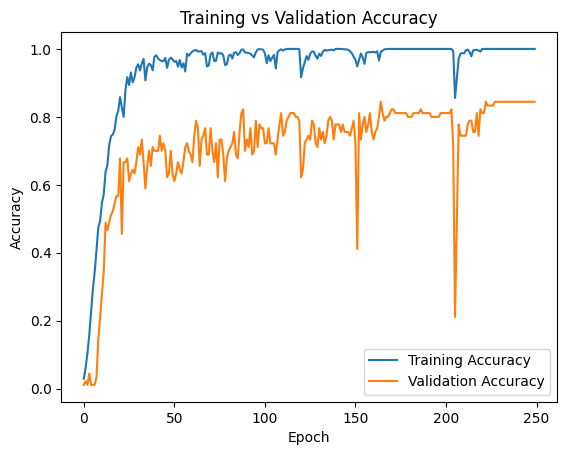

In [32]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have a `history` object
history = multi_cnn_model_CS.fit(x_train_CS, y_train_CS, epochs=250, batch_size=32, validation_data=(x_valid_CS, y_valid_CS))

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [33]:
x_test_CS = np.reshape(x_test_CS, (1078, 237, 150, 1))

In [34]:
# Predict classes using the test data
predictions_CS = multi_cnn_model_CS.predict(x_test_CS)
predicted_classes_CS = np.argmax(predictions_CS, axis=1)


34/34 [==============================] - 4s 73ms/step


In [35]:
# True classes
true_classes_CS = np.argmax(y_test_CS, axis=1)

In [36]:
# Compare predicted classes with true classes and calculate accuracy
accuracy_CS = np.mean(predicted_classes_CS == true_classes_CS)
print("Accuracy (CS):", accuracy_CS)

Accuracy (CS): 0.45454545454545453


In [37]:
# Print some of the predicted and true classes
print("Predicted Classes (CS):", predicted_classes_CS[:10])
print("True Classes (CS):", true_classes_CS[:10])

Predicted Classes (CS): [ 0 10  2  3 42 41  6 15 58  9]
True Classes (CS): [0 1 2 3 4 5 6 7 8 9]


In [38]:
# Train the model
#multi_cnn_model_CV.fit(x_train_CV, y_train_CV, validation_data=(x_valid_CV, y_valid_CV), epochs=150, batch_size=32)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have a `history` object
history = multi_cnn_model_CV.fit(x_train_CV, y_train_CV, epochs=250, batch_size=32, validation_data=(x_valid_CV, y_valid_CV))

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Epoch 1/250
57/57 [==============================] - 65s 254ms/step - loss: 4.6711 - accuracy: 0.0380 - val_loss: 4.1026 - val_accuracy: 0.0625
Epoch 2/250
57/57 [==============================] - 11s 189ms/step - loss: 3.7541 - accuracy: 0.0732 - val_loss: 4.3448 - val_accuracy: 0.0104
Epoch 3/250
57/57 [==============================] - 11s 185ms/step - loss: 3.1671 - accuracy: 0.1410 - val_loss: 5.0136 - val_accuracy: 0.0208
Epoch 4/250
57/57 [==============================] - 11s 187ms/step - loss: 2.7676 - accuracy: 0.2098 - val_loss: 5.4471 - val_accuracy: 0.0104
Epoch 5/250
57/57 [==============================] - 10s 184ms/step - loss: 2.4372 - accuracy: 0.2704 - val_loss: 6.7425 - val_accuracy: 0.0208
Epoch 6/250
57/57 [==============================] - 10s 184ms/step - loss: 2.1312 - accuracy: 0.3464 - val_loss: 7.3553 - val_accuracy: 0.0208
Epoch 7/250
57/57 [==============================] - 11s 186ms/step - loss: 2.0073 - accuracy: 0.3678 - val_loss: 5.1330 - val_accuracy:

In [ ]:
x_test_CV = np.reshape(x_test_CV, (960, 237, 150, 1))

In [ ]:
predictions_CV = multi_cnn_model_CV.predict(x_test_CV)
predicted_classes_CV = np.argmax(predictions_CV, axis=1)

In [ ]:
true_classes_CV = np.argmax(y_test_CV, axis=1)

In [ ]:
accuracy_CV = np.mean(predicted_classes_CV == true_classes_CV)
print("Accuracy (CV):", accuracy_CV)

In [ ]:
print("Predicted Classes (CV):", predicted_classes_CV[:10])
print("True Classes (CV):", true_classes_CV[:10])